WARNING    Cannot use Cython, a test compilation failed: [WinError 3] O sistema não pode encontrar o caminho especificado: 'C:\\Program Files (x86)\\Microsoft Visual Studio 14.0\\VC\\PlatformSDK\\lib' (FileNotFoundError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


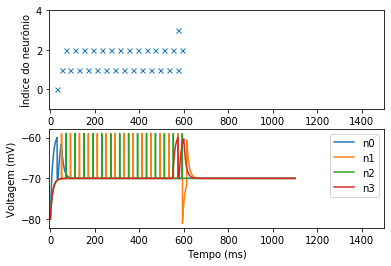

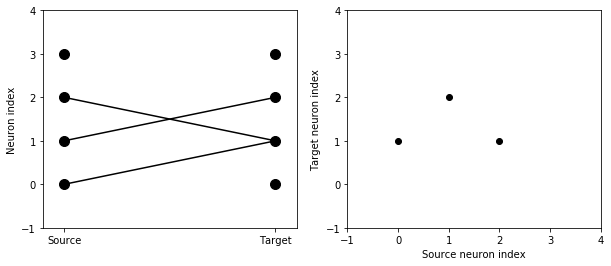

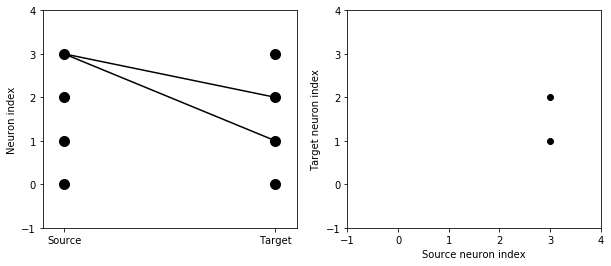

In [1]:
from brian2 import *
%matplotlib inline

N = 4 # Número de neurônios
vrest = -70.0*mV # Potencial de repouso
tau = 10*ms
R = 100*Mohm
w_exc = 11*mV # Peso sináptico
w_inh = -11*mV

# Modelo Leaky Integrate and Fire LIF
eqs = '''
    dv/dt = ((vrest - v) + R*I)/tau : volt (unless refractory)
    I : amp
    '''

# Criação dos neurônios
neurons = NeuronGroup(N, eqs, threshold = 'v > -60.0*mV', reset = 'v = vrest', refractory = 5*ms, method = 'linear')

#Criação da sinapse excitatória
syn_ex = Synapses(neurons, neurons, on_pre='v_post += w_exc', delay = 20*ms)
syn_ex.connect(i=1, j=2)
syn_ex.connect(i=2, j=1)
syn_ex.connect(i=0, j=1)

#Criação da sinapse inibitória
syn_in = Synapses(neurons, neurons, on_pre='v_post += w_inh', delay = 20*ms)
syn_in.connect(i=3, j=1)
syn_in.connect(i=3, j=2)

#Funções para extrair dados da simulação 
state_mon = StateMonitor(neurons, 'v', record = True)
spike_mon = SpikeMonitor(neurons)
rate_mon = PopulationRateMonitor(neurons) # capturar a frequência instantânea da rede

#Valores iniciais de tensão e corrente na entrada dos neurônios
neurons.v = [-80, -80, -80, -80]*mV
neurons.I = [110, 0, 0, 0]*pA 
run (50*ms) # Simulação por 50 ms com corrente em n0 (exc), para depois zerar as correntes iniciais

neurons.I = [0, 0, 0, 0]*pA
run (500*ms) # Simulação sem corrente de estímulo, mantendo apenas a reverberação dos neurônios

neurons.I = [0, 0, 0, 110]*pA
run (50*ms) # Simulação por 50 ms com corrente em n3 (inh), para depois zerar as correntes

neurons.I = [0, 0, 0, 0]*pA
run (500*ms) # Simulação sem corrente de estímulo, mantendo apenas a reverberação dos neurônios

# Raster plot
subplot(211)
plot(spike_mon.t/ms, spike_mon.i, 'x', markersize = 5)
xlabel('Tempo (ms)')
ylabel('Índice do neurônio')
xlim(-5, 1500)
ylim(-1, 4)

#subplot(312)
#plot(rate_mon.t/ms,rate_mon.rate/Hz)
#xlabel('Tempo (ms)')
#ylabel('Índice do neurônio')
#xlim(-5, 250)

# Tensão de disparos
subplot(212)
plot(state_mon.t/ms, state_mon.v[0]/mV, label="n0")
plot(state_mon.t/ms, state_mon.v[1]/mV, label="n1")
plot(state_mon.t/ms, state_mon.v[2]/mV, label="n2")
plot(state_mon.t/ms, state_mon.v[3]/mV, label="n3")
xlabel('Tempo (ms)')
ylabel('Voltagem (mV)')
xlim(-5, 1500)
legend()

show()


def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

visualise_connectivity(syn_ex)
visualise_connectivity(syn_in)